In [ ]:
# default_exp modeling

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# modeling

> This module contains custom models, loss functions, and a default layer group splitter for use in applying discriminiative learning rates to your Huggingface models

In [ ]:
#export
from blurr.utils import *
from blurr.data import *

import torch
from transformers import *
from fastai2.text.all import *

In [ ]:
#hide
import pdb

from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#cuda
torch.cuda.set_device(1)
print(f'Using GPU #{torch.cuda.current_device()}: {torch.cuda.get_device_name()}')

Using GPU #1: GeForce GTX 1080 Ti


In [ ]:
#export
def hf_splitter(m):
    root_modules = list(m.hf_model.named_children())
    top_module_name, top_module = root_modules[0]
    
    groups = L([ m for m_name, m in list(top_module.named_children()) ])
    groups += L([ m for m_name, m in root_modules[1:] ])

    return groups.map(params).filter(lambda el: len(el) > 0)

In [ ]:
#export
class HF_BaseModelWrapper(torch.nn.Module):
    def __init__(self, hf_model):
        super().__init__()
        self.hf_model = hf_model
        self.hf_model_fwd_args = hf_model.forward.__code__.co_varnames
        
    def forward(self, x):
        model_kwargs = {}
        model_kwargs['input_ids'] = x[0]
        if (self._include_arg('token_type_ids', x[1])): model_kwargs['token_type_ids'] = x[1]
        if (self._include_arg('attention_mask', x[2])): model_kwargs['attention_mask'] = x[2]
        
        outputs = self.hf_model(**model_kwargs)
        return outputs[0]
    
    def _include_arg(self, arg_name, tensor_val):
        if (tensor_val[0][0].item() == -9999 or arg_name not in self.hf_model_fwd_args):
            return False
        return True

Sequence classification

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)

model_path = Path('models')
imdb_df = pd.read_csv(path/'texts.csv')

In [ ]:
imdb_df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
task = HF_TASKS_AUTO.ForSequenceClassification

pretrained_model_name = "roberta-base" # "distilbert-base-uncased" "bert-base-uncased"
config = AutoConfig.from_pretrained(pretrained_model_name)

hf_arch, hf_tokenizer, hf_config, hf_model = BLURR_MODEL_HELPER.get_auto_hf_objects(pretrained_model_name, 
                                                                                    task=task, 
                                                                                    config=config)

In [ ]:
# single input
blocks = (
    HF_TextBlock.from_df(text_cols_lists=[['text']], hf_arch=hf_arch, hf_tokenizer=hf_tokenizer),
    CategoryBlock
)

def get_x(x): 
    return x.text0

dblock = DataBlock(blocks=blocks, 
                   get_x=get_x,
                   get_y=ColReader('label'), 
                   splitter=ColSplitter(col='is_valid'))

In [ ]:
dls = dblock.dataloaders(imdb_df, bs=4)

In [ ]:
dls.show_batch(hf_tokenizer=hf_tokenizer, max_n=2)

,text,category
0,"<s>Raising Victor Vargas: A Review<br /><br />You know, Raising Victor Vargas is like sticking your hands into a big, steaming bowl of oatmeal. It's warm and gooey, but you're not sure if it feels right. Try as I might, no matter how warm and gooey Raising Victor Vargas became I was always aware that something didn't quite feel right. Victor Vargas suffers from a certain overconfidence on the director's part. Apparently, the director thought that the ethnic backdrop of a Latino family on the lower east side, and an idyllic storyline would make the film critic proof. He was right, but it didn't fool me. Raising Victor Vargas is the story about a seventeen-year old boy called, you guessed it, Victor Vargas (Victor Rasuk) who lives his teenage years chasing more skirt than the Rolling Stones could do in all the years they've toured. The movie starts off in `Ugly Fat' Donna's bedroom where Victor is sure to seduce her, but a cry from outside disrupts his plans when his best-friend Harold (Kevin Rivera) comes-a-looking for him. Caught in the attempt by Harold and his sister, Victor Vargas runs off for damage control. Yet even with the embarrassing implication that he's been boffing the homeliest girl in the neighborhood, nothing dissuades young Victor from going off on the hunt for more fresh meat. On a hot, New York City day they make way to the local public swimming pool where Victor's eyes catch a glimpse of the lovely young nymph Judy (Judy Marte), who's not just pretty, but a strong and independent too. The relationship that develops between Victor and Judy becomes the focus of the film. The story also focuses on Victor's family that is comprised of his grandmother or abuelita (Altagracia Guzman), his brother Nino (also played by real life brother to Victor, Silvestre Rasuk) and his sister Vicky (Krystal Rodriguez). The action follows Victor between scenes with Judy and scenes with his family. Victor tries to cope with being an oversexed pimp-daddy, his feelings for Judy and his grandmother's conservative Catholic upbringing.<br /><br />The problems that arise from Raising Victor Vargas are a few, but glaring errors. Throughout the film you get to know certain characters like Vicky, Nino, Grandma,</s>",negative
1,"<s>I rented the dubbed-English version of Lensman, hoping that since it came from well-known novels it would have some substance. While there were hints of substance in the movie, it mostly didn't rise above the level of kiddie cartoon. Maybe the movie was a bad adaptation of the book, or it lost a lot in the dubbed version. Or maybe even the source novels were lightweight. But for whatever reason, there wasn't much there.<br /><br />I noticed lots of details that were derivative, sloppy, poorly dramatized, or otherwise deficient. Some examples: The opening scenes looked borrowed from the 2001 ""star gate"" scene and the Star Wars image of hyperspace. The robot on the harvester looked like an anthropomorphized ""R2-D2"".<br /><br />It starts out trying to borrow its comic relief style of Star Wars, but mercifully (since the humor doesn't work) gives up on comedy and plays it serious. In that sense, it's superior to the Star Wars franchise, which started with a clever sense of humor, and eventually deteriorated to Jar-Jar's annoying silliness.<br /><br />The agricultural details were apparently drawn by someone who had never seen a farm. The harvester was driving through the unharvested middle of a field, dumping silage onto unharvested crops, rather than working from one side to the other and dumping the silage onto already-harvested rows or into a truck. Corn (maize) was pouring out the grain chute, but the farm lands were drawn like a wheat field.<br /><br />When it was time for Kim's father had to face his fate, there wasn't any dramatic weight to the scene. That could have been partly the fault of the English-language voice actor, but the drawings didn't show much weight either. Kim's reactions 

In [ ]:
model = HF_BaseModelWrapper(hf_model)

In [ ]:
learn = Learner(dls, 
                model,
                opt_func=partial(Adam, decouple_wd=True),
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy],
#                 cbs=[MixedPrecision(clip=0.1)],
                splitter=hf_splitter).to_fp16(clip=None)


learn.create_opt()             # -> will create your layer groups based on your "splitter" function
learn.freeze()

In [ ]:
# learn.summary()

In [ ]:
print(len(learn.opt.param_groups))

4


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=0.04786301031708717)

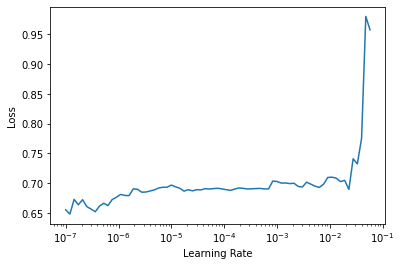

In [ ]:
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(3, lr_max=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.695042,0.864233,0.465000,00:17
1,0.574407,0.532043,0.800000,00:17
2,0.491104,0.509210,0.790000,00:17


In [ ]:
learn.predict('I really liked the movie')

('positive', tensor(1), tensor([0.3969, 0.6031]))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(3, lr_max=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.355951,0.241148,0.915000,00:49
1,0.181225,0.215573,0.920000,00:49
2,0.087436,0.228844,0.925000,00:50


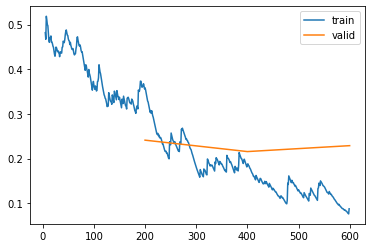

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.predict("This was a really good movie, ")

('positive', tensor(1), tensor([0.0148, 0.9852]))

In [ ]:
learn.predict("Acting was so bad it was almost funny.")

('negative', tensor(0), tensor([0.9813, 0.0187]))

And what about inference?

In [ ]:
learn.export(fname='seq_class_learn_export.pkl')

In [ ]:
inf_learn = load_learner(fname='seq_class_learn_export.pkl')
inf_learn.predict("This movie should not be seen by anyone!!!!")

('negative', tensor(0), tensor([0.8439, 0.1561]))

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_utils.ipynb.
Converted 01_data.ipynb.
Converted 02_modeling.ipynb.
Converted index.ipynb.
